In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [41]:
df = pd.read_csv("initial_dataset_final.csv")
df.head()

,season,hPos,hGSPG,hGCPG,hCSPG,hPtsPG,aPos,aGSPG,aGCPG,aCSPG,aPtsPG,target
0,1,1.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0
1,1,4.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,1
2,1,5.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,2
3,1,6.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1
4,1,7.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,1


# Target Value Counts

In [3]:
winners = df['target'].tolist()
winners_count = {"Away Win":0,"Draw":0,"Home Win":0}
for w in winners:
    if w == 0:
        winners_count["Away Win"] += 1
    elif w == 1:
        winners_count["Draw"] += 1
    elif w == 2:
        winners_count["Home Win"] += 1
    else:
        print("Invalid Value: {}".format(w))
print(winners_count)

{'Away Win': 2775, 'Draw': 2676, 'Home Win': 4675}


In [4]:
home_team_accuracy = round((4675/(4675+2775+2676))*100,2)
print("Therefore can reach a {}% accuracy by always predicting home team win".format(home_team_accuracy))

Therefore can reach a 46.17% accuracy by always predicting home team win


# Upsets

In [5]:
def test_expected_result_ignore_draws(hPos,aPos,result):
    if hPos < aPos:
        if result == 2:
            return True
    else:
        if result == 0:
            return True
    return False

In [6]:
def expected_result_ignore_draws(row):
    hPos = int(row['hPos'])
    aPos = int(row['aPos'])
    result = int(row['target'])
    return test_expected_result_ignore_draws(hPos,aPos,result)

In [7]:
df['Expected Result (Ignore Draws)'] = df.apply(expected_result_ignore_draws,axis=1)

In [8]:
df['Expected Result (Ignore Draws)'].value_counts()

False    5439
True     4687
Name: Expected Result (Ignore Draws), dtype: int64

In [9]:
# Therefore in 4687 of the games where it's not a draw, the higher placed team wins.

In [10]:
4687/10126

0.46286786490223186

## Considering Draws

In [11]:
def test_expected_result(hPos,aPos,result,draw_threshold):
    if abs(hPos-aPos) <= draw_threshold:
        if result == 1:
            return True
        else:
            return False
    else:
        return test_expected_result_ignore_draws(hPos,aPos,result)

def expected_result(row,draw_threshold):
    hPos = int(row['hPos'])
    aPos = int(row['aPos'])
    result = int(row['target'])
    return test_expected_result(hPos,aPos,result,draw_threshold)

In [12]:
df['Expected Result (3)'] = df.apply(expected_result,args=(3,),axis=1)
df['Expected Result (3)'].value_counts()

False    5706
True     4420
Name: Expected Result (3), dtype: int64

In [13]:
df['Expected Result (2)'] = df.apply(expected_result,args=(2,),axis=1)
df['Expected Result (2)'].value_counts()

False    5641
True     4485
Name: Expected Result (2), dtype: int64

In [14]:
df['Expected Result (1)'] = df.apply(expected_result,args=(1,),axis=1)
df['Expected Result (1)'].value_counts()

False    5497
True     4629
Name: Expected Result (1), dtype: int64

In [15]:
5004/10126

0.49417341497136086

In [16]:
df['Expected Result (0)'] = df.apply(expected_result,args=(0,),axis=1)
df['Expected Result (0)'].value_counts()

False    5439
True     4687
Name: Expected Result (0), dtype: int64

These results imply that we can almost reach a 46% accuracy by simply always predicting the expected result, which is defined as a draw if teams are 0 positions apart, and a win for better position team otherwise.

This also imples that draws are quite hard to predict, so let's investigate if that's true.

# Draws

In [17]:
df_draws = df.query("target == 1").copy()

In [18]:
df_draws.shape

(2676, 17)

In [19]:
def get_pos_diff(row):
    return abs(int(row["hPos"]) - int(row['aPos']))

In [20]:
df_draws['pos_diff'] = df_draws.apply(get_pos_diff,axis=1)

[Text(0, 0.5, 'Proportion of total Draws'),
 Text(0.5, 0, 'Position Difference between Teams (absolute)'),
 Text(0.5, 1.0, 'Draws')]

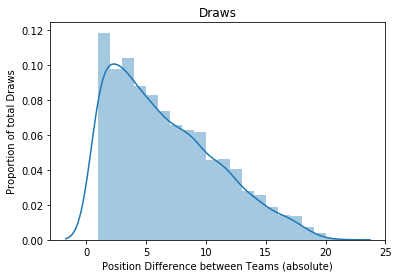

In [21]:
ax = sns.distplot(df_draws['pos_diff'].tolist(),bins=20)
ax.set(xlabel='Position Difference between Teams (absolute)', ylabel='Proportion of total Draws', title="Draws")

This shows a clear correlation: Given a game is a draw, it's linearly more likely that the teams are close together in the league table.

This encouraged me to run the same test for Home Wins and Away Wins

# Home Wins

In [22]:
df_home = df.query("target == 2").copy()

In [23]:
def home_pos_diff(row):
    return (int(row['hPos']) - int(row['aPos']))

In [24]:
df_home['pos_diff'] = df_home.apply(home_pos_diff,axis=1)

In [25]:
df_home['pos_diff'].value_counts()

-2     264
-1     244
-4     239
 1     220
-8     215
-3     207
 3     205
-6     205
-5     198
 2     192
-7     186
-9     174
 4     161
-10    148
 5     144
 6     142
-12    140
-11    131
 7     130
-13    124
 8     110
 9      93
-14     84
 10     82
 12     80
-15     80
 11     78
-16     74
 13     62
 14     58
-17     51
-18     44
 16     32
 15     32
 17     16
-19     15
 18      7
 19      3
-20      2
-21      2
 21      1
Name: pos_diff, dtype: int64

[Text(0, 0.5, 'Proportion of total Home Wins'),
 Text(0.5, 0, 'Position Difference between Teams (Home - Away)'),
 Text(0.5, 1.0, 'Home Wins')]

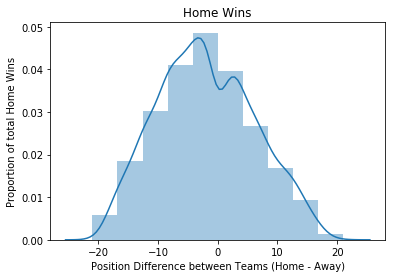

In [26]:
ax2 = sns.distplot(df_home['pos_diff'].tolist(),bins=10)
ax2.set(xlabel='Position Difference between Teams (Home - Away)', ylabel='Proportion of total Home Wins', title="Home Wins")

This implies that it doesn't really matter if teams are ahead or behind, the benefit of being the home team seems far stronger

# Away Wins

In [27]:
df_away = df.query("target == 0").copy()

In [28]:
def away_pos_diff(row):
    return (int(row['aPos']) - int(row['hPos']))

In [29]:
df_away['pos_diff'] = df_away.apply(away_pos_diff,axis=1)

In [30]:
df_away['pos_diff'].value_counts()

-4     154
-5     144
-2     142
-6     137
-3     137
 1     132
-1     131
-8     121
 2     118
-9     116
-7     114
-10    106
 3     102
-12     96
-11     93
 5      93
 4      84
-14     81
-15     67
-13     64
 6      63
-16     56
 8      55
-17     52
 7      48
 10     46
 11     35
-18     34
 9      30
 14     29
 12     22
 13     17
 15     16
-19     15
 16     10
 17      9
 18      5
 19      1
Name: pos_diff, dtype: int64

[Text(0, 0.5, 'Proportion of total Away Wins'),
 Text(0.5, 0, 'Position Difference between Teams (Away - Home)'),
 Text(0.5, 1.0, 'Away Wins')]

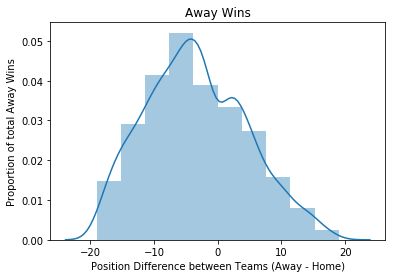

In [31]:
ax3 = sns.distplot(df_away['pos_diff'].tolist(),bins=10)
ax3.set(xlabel='Position Difference between Teams (Away - Home)', ylabel='Proportion of total Away Wins', title="Away Wins")

# Pos-diff Distributions

In [32]:
df['pos_diff'] = df.apply(home_pos_diff,axis=1)

[Text(0, 0.5, 'Proportion of total games'),
 Text(0.5, 0, 'Position Difference between Teams (Home - Away)'),
 Text(0.5, 1.0, 'All Games')]

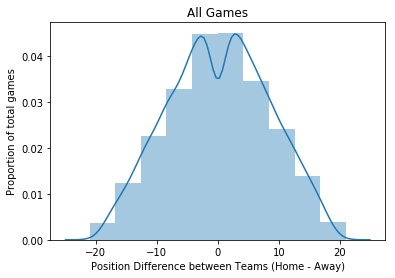

In [33]:
ax4 = sns.distplot(df['pos_diff'].tolist(),bins=10)
ax4.set(xlabel='Position Difference between Teams (Home - Away)', ylabel='Proportion of total games', title="All Games")

In [34]:
def pos_diff_to_category(row):
    pos_diff = int(row['pos_diff'])
    if pos_diff <= -15:
        return "<= -15"
    elif pos_diff <= -10:
        return "-15 < x <= -10"
    elif pos_diff <= -5:
        return "-10 < x <= -5"
    elif pos_diff <= 0:
        return "-5 < x <= 0"
    elif pos_diff < 5:
        return "0 < x <= 4"
    elif pos_diff < 10:
        return "4 < x <= 9"
    elif pos_diff < 15:
        return "9 < x <= 14"
    else:
        return ">= 15"

In [35]:
df["pos_diff_cat"] = df.apply(pos_diff_to_category,axis=1)

In [36]:
def pair_cols(row,col1,col2):
    val1 = str(row[col1])
    val2 = str(row[col2])
    return str(val1 + "|" + val2)

In [37]:
df['pos_diff_result_pairs'] = df.apply(pair_cols,args=("pos_diff_cat","target"),axis=1)
df['pos_diff_result_pairs'].value_counts()

-10 < x <= -5|2     978
-5 < x <= 0|2       954
0 < x <= 4|2        778
4 < x <= 9|0        632
-15 < x <= -10|2    627
4 < x <= 9|2        619
0 < x <= 4|1        575
0 < x <= 4|0        564
4 < x <= 9|1        525
-5 < x <= 0|1       519
9 < x <= 14|0       440
-5 < x <= 0|0       436
-10 < x <= -5|1     403
9 < x <= 14|2       360
-10 < x <= -5|0     289
9 < x <= 14|1       270
<= -15|2            268
-15 < x <= -10|1    227
>= 15|0             224
-15 < x <= -10|0    149
>= 15|1              95
>= 15|2              91
<= -15|1             62
<= -15|0             41
Name: pos_diff_result_pairs, dtype: int64

Since we are only interested in predicting the target, given the pos_diff values, let's group these by pos_diff category

In [38]:
def result_counts_dict_for_pos_diff_cats(pos_diff_cats,results):
    #outer_dict = {"<= -15":{},"-15 < x <= -10":{},"-10 < x <= -5":{},"-5 < x <= 0":{},"0 < x <= 4":{},"4 < x <= 9":{},"9 < x <= 14":{},">= 15":{}}
    outer_dict = {}
    for cat in set(pos_diff_cats):
        outer_dict[cat] = {0:0,1:0,2:0}
    for i in range(len(pos_diff_cats)):
        inner_dict = outer_dict.get(pos_diff_cats[i])
        inner_dict[results[i]] += 1
        outer_dict[pos_diff_cats[i]] = inner_dict
    return outer_dict

In [39]:
dists = result_counts_dict_for_pos_diff_cats(df['pos_diff_cat'].tolist(),df['target'].tolist())

In [40]:
dists

{'<= -15': {0: 41, 1: 62, 2: 268},
 '9 < x <= 14': {0: 440, 1: 270, 2: 360},
 '-15 < x <= -10': {0: 149, 1: 227, 2: 627},
 '>= 15': {0: 224, 1: 95, 2: 91},
 '0 < x <= 4': {0: 564, 1: 575, 2: 778},
 '4 < x <= 9': {0: 632, 1: 525, 2: 619},
 '-5 < x <= 0': {0: 436, 1: 519, 2: 954},
 '-10 < x <= -5': {0: 289, 1: 403, 2: 978}}

This clearly shows that some categories of differences in positions between the teams are far easier to predict than others. For example, by simply predicting the most common occurence of each category, we can get a 50%+ accuracy for the 5 (out of 8 total) following categories: '-15 < x <= -10', '-10 < x <= -5', '-5 < x <= 0', '<= -15' and '>= 15'.

This implies that the categories '4 < x <= 9', '0 < x <= 4', and '9 < x <= 14' are far harder to predict. Looking at these categories, you see that they form a continuous outer group from 0 < x <= 14. This group represents all the cases where the AWAY TEAM IS PERFORMING BETTER IN THE LEAGUE THAN THE HOME TEAM. This is due to the overlapping of two trends: In one case, the home team tends to win, pulling all predictions in that direction. Additionally, the better placed team tends to win, pulling all predictions in that direction. Clearly, in the range of hPos-aPos being between 0 and 14, these pulls interact and almost balance eachother out, making predictions a much more complicated problem.

# League Table Statistics

In [43]:
df.head()

,season,hPos,hGSPG,hGCPG,hCSPG,hPtsPG,aPos,aGSPG,aGCPG,aCSPG,aPtsPG,target
0,1,1.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0
1,1,4.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,1
2,1,5.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,2
3,1,6.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1
4,1,7.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,1


In [54]:
subset = df[['hGSPG','hCSPG','hGCPG','hPtsPG']]

/home/joe/anaconda3/envs/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


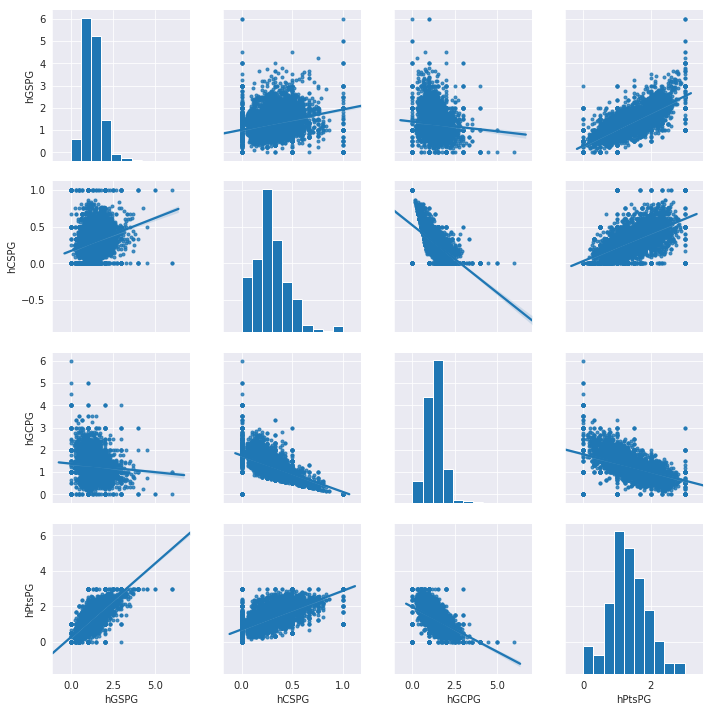

In [56]:
sns.set_style("darkgrid")
sns.pairplot(subset, kind="reg",markers=['.'])